<a href="https://colab.research.google.com/github/AlexandreAdam/ProbabilisticGraphicalModels/blob/master/hw3_AlexandreAdam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6269 - Homework 3 - EM and Gaussian mixtures
**Due:**  Tuesday, November 3, 2020

#### Name: Alexandre Adam
#### Student ID: 20090755
#### Collaborators: Ronan Legin, Olivier Vincent 



## Introduction

The file `EMGaussian.train` contains samples of data $\{x_n\}_{n=1}^N$ where $x_n \in \mathbb{R}^2$, with one datapoint per row. The goal of this exercise is to implement the K-Means and EM algorithms using $K=4$ components/clusters. 

### Tasks
0.   Get your own copy of this file via "File > Save a copy in Drive...",
1.   Fill your personal information and collaborators at the top of this assignment, and rename the notebook accordingly, e.g., `hw3_thomasBayes.ipynb`
2.   Read the instructions provided on each section and cell carefully,
4.   Implement the requested algorithms in section **Playground**
5.   In section **Model Comparison**, simply execute the cells (without changing the code) and type your answers to the questions in the provided text cells.
    
**Important**: You are allowed to collaborate with other students in both the math and coding parts of this assignment. However, the answers provided here must reflect your individual work. For that reason, you are not allowed to share this notebook, except for your submission to the TA for grading. **Don't forget to pin and save the version of the notebook you want to be graded on!**

In [ ]:
!wget http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A20/notes/hwk3data.zip
!unzip hwk3data.zip

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

X_train = np.loadtxt("/content/hwk3data/EMGaussian.train")
X_test = np.loadtxt("/content/hwk3data/EMGaussian.test")

--2020-11-03 13:26:20--  http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A20/notes/hwk3data.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7269 (7.1K) [application/zip]
Saving to: ‘hwk3data.zip’

hwk3data.zip        100%[===================>]   7.10K  --.-KB/s    in 0s      

2020-11-03 13:26:20 (689 MB/s) - ‘hwk3data.zip’ saved [7269/7269]

Archive:  hwk3data.zip
  inflating: hwk3data/EMGaussian.test  
  inflating: hwk3data/EMGaussian.train  


## Playground

You are allowed to add as many cells and functions as you wish in this section, but not allowed to change the signature (name and inputs) of the functions!

In [ ]:
# ---------------------------------------------------------------------------
#                       Code for plotting the results 
#                      ! DO NOT MODIFY THESE FUNCTIONS !
# ---------------------------------------------------------------------------

from matplotlib.patches import Ellipse
def plot_ellipse(ax, mu, sigma, alpha=1, color="k"):
    evals, evecs = np.linalg.eigh(sigma)
    x, y = evecs[:, 0]
    theta = np.degrees(np.arctan2(y, x))
    for factor in [1.5, 3]:
        w, h = factor * np.sqrt(evals)
        ellipse = Ellipse(mu, w, h, theta, facecolor='none', edgecolor=color) 
        ellipse.set_alpha(alpha)
        ax.add_artist(ellipse) 
        
def show_kmeans(X_train, X_test, KM_centroids, KM_predictor):
    
    shapes = ['o', '*', 'v', '+']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b',
              '#e377c2', '#7f7f7f', '#bcbd22']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    for (ax, data, title) in [(ax1, X_train, 'Training Set'), (ax2, X_test, 'Test Set')]:
        pred_labels, obj = KM_predictor(data)
        print("K-Means Objective on " + title + ": ", obj)
        cs = [colors[int(_) % len(colors)] for _ in pred_labels]
        ax.scatter(data[:, 0], data[:, 1], alpha=0.5, c=cs)
        ax.scatter(KM_centroids[:, 0], KM_centroids[:, 1], marker='o', c='#d62728')
        ax.set_title(title)
        ax.set_xlim(-12, 12), ax.set_ylim(-12, 12)
        ax.set_aspect('equal')    
        
    plt.show()
    print('\n')
    
    
def show_mog(X_train, X_test, MoG_pi, MoG_centroids, MoG_sigmas, MoG_predictor):
    
    shapes = ['o', '*', 'v', '+']  
    colors = [[31, 119, 180], [255, 127, 14], [44, 160, 44], [148, 103, 189],
             [140, 86, 75], [227, 119, 194], [127, 127, 127], [188, 189, 34]]
    
    max_pi = np.max(MoG_pi)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    for (ax, data, title) in [(ax1, X_train, 'Training Set'), (ax2, X_test, 'Test Set')]:
        pred_labels, norm_llike = MoG_predictor(data)
        print("MoG Normalized Log-Likelihood " + title + ": ", norm_llike)
        cs = [colors[int(_) % len(colors)] + [0.5*255*MoG_pi[_]/max_pi] for _ in pred_labels]
        ax.scatter(data[:, 0], data[:, 1], c=np.array(cs)/255.)
        ax.scatter(MoG_centroids[:, 0], MoG_centroids[:, 1], marker='o', c='#d62728')
        ax.set_title(title)
        ax.set_xlim(-12, 12), ax.set_ylim(-12, 12)
        ax.set_aspect('equal')    
        
        for _ in range(MoG_pi.shape[0]):
            plot_ellipse(ax, MoG_centroids[_, :], MoG_sigmas[_, :,:], alpha=MoG_pi[_]/max_pi, color='k')
    
    plt.show()
    print('\n')

## K mean algorithm

We define the objective function
$$
  J(z, \mu) \overset{\Delta}{=} \sum_{i = 1}^N \sum_{j = 1}^k z_{i,j} ||\mathbf{x}_i - \mu_j||^2_2
$$
where $z_{i, j}$ is the cluster assignement of the i-th example to the j-th cluster and $\mu_j$ is the mean of the j-th cluster. Also $\mathbf{x}$ and $\mu_j$ are $d$-vector, where $d$ is the feature dimension. We used the notation $||\cdot ||_2$ for the 2-norm, or Euclidian norm.

The expectation maximization agorithm will try to minimize this objective function. Therefore, we can set our convergence criterion to the moment where the objective function stops decreasing significantly using the treshold $\epsilon$.


1.   Initialize $\mu^{(1)} $
2.   Iterate untile convergence ($J^{(i + 1)} > J^{(i)} - \epsilon$)
     1. Expectation step: $z^{(i + 1)} = \underset{z}{\text{argmin}} J(z, \mu^{(i)})$
     2. Maximization step: $\mu^{(i + 1)} = \underset{\mu \in \mathbb{R}^{k}}{\text{argmin}} J(z^{(i + 1)}, \mu)$  

First, we derive the mean for the minimization step assuming $N$ examples and $k$ clusters
$$
\partial_{\mu_\ell} J(z, \mu) =  -2\sum_{i = 1}^N \sum_{j = 1}^k z_{i,j} (\mathbf{x}_i - \mu_j)\delta_{j \ell}
$$
where we used the Kronecker delta $\delta_{j \ell}$ for the derivative $\dfrac{\partial \mu_j}{\partial \mu_\ell}$. Since $z_{i, j} = 1$ only for examples that belong to the cluster $j$, we can rewrite this using $j = \ell$ (simplification required by the Kronecker delta):
$$
  \partial_{\mu_\ell} J(z, \mu) =  -2\sum_{i = 1}^N z_{i,\ell} (\mathbf{x}_i - \mu_\ell)
$$ 
At the minimum, this expression is $0$ and we obtain the empirical cluster mean (called centroids)
$$
  \hat{\mu}_\ell = \frac{1}{\displaystyle \sum_{i} z_{i, \ell}} \sum_i z_{i, \ell} \mathbf{x}_i
$$

For the expectation step, the task is a little bit more subtle since we require 
$z_i$ to be a one-hot vector. Therefore, our task is to pick the index $j^*$ such that
$$
 j^* = \text{argmin} ||x_i - \mu_j||^2_2
$$
for every example $i$.


# Gaussian Mixture Model

This is a graphical model with latent variable $\mathbf{z}_i$ for each observations ($i=1,\dots, N$) and latent variables $\mu_j$ and $\Sigma_j$ for each cluster $j = 1,\dots,k$. The $z_{i}$ are distributed with a $k$-Categorical distribution. The Multinoulli is a natural choice.
$$
  \mathbf{z}_i \sim \text{Multinoulli}(\pi_{1,\dots,k})
$$
We then assume the conditional over an observation $\mathbf{x}_i$ assigned to the cluster $j$ ($z_{i, j} = 1$) to follow a multivariate normal distribution
$$
\mathbf{x}_i \mid z_{i, j} = 1 \sim \mathcal{N}(\mu_j, \Sigma_j)
$$
where $\mathbf{x}$ and $\mu_j$ are $d$-vectors, and the covariance matrix is a positive semi-definite, symmetric $d \times d$ matrix. Using the notation 
$$
\theta = (\pi, (\mu_j)_{j = 1}^k, (\Sigma_j)_{j = 1}^k)
$$
for the latent parameters, we get the expected log-likelihood is 

$$
\mathcal{L} =  \mathbb{E}_q\left[\log p(\mathbf{x}, \mathbf{z} \mid  \theta) \right] 
 =  \sum_{i = 1}^N \sum_{j = 1}^k  
    \mathbb{E}_q[z_{i, j}] (\log \mathcal{N}(\mathbf{x}_i \mid \mu_j , \Sigma_j) 
    +  \log \pi_j)
$$
The expectation is taken with respect to the marginal distribution of the cluster assignement variable $z_i$:
$$
 q^{(t + 1)}(\mathbf{z}) = p(\mathbf{z} \mid \mathbf{x}_i , \theta^{(t)})
$$
For a single observation, this is 
$$
  q^{(t + 1)}(\mathbf{z}_i) = p(\mathbf{z}_i \mid \mathbf{x}_i , \theta^{(t)})
$$
Using Bayes theorem, 
$$
  q^{(t + 1)}(\mathbf{z}_i) = \frac{p(\mathbf{x}_i \mid \mathbf{z}_i,  \theta^{(t)}) p(\mathbf{z}_i \mid \pi^{(t)})}{p(\mathbf{x}_i \mid \theta^{(t)})}
$$

We define the weight $\Upsilon_{i, j}$ to be the probability $\Upsilon_{i, j}^{(t + 1)} = q^{(t + 1)}(z_{i, j} = 1)$

Using the expressions for the conditional and the prior on the latent variable $z_{i, j} = 1$, we can write
$$
  \Upsilon^{(t + 1)}_{i, j} = \frac{\pi_j^{(t)} \mathcal{N}(\mathbf{x}_i \mid \mu_j^{(t)}, \Sigma_j^{(t)})}{\displaystyle \sum_{\ell = 1}^k \pi_\ell^{(t)} \mathcal{N}(\mathbf{x}_i \mid \mu_\ell^{(t)}, \Sigma_\ell^{(t)})} 
$$

We outline here the EM algorithm for the GMM:

  1. Initialize $\mu^{(1)}$ with k-means++;
  2. Initialize $\Sigma_j^{(1)}$ with a large spherical covariance $\sigma^2 \mathbf{1}$, $\sigma^2 \gg 1$;
  3. Initialize $\pi_j^{(1)}$ with the proportions of each class from k-means++;
  4. Iterate until convergence ($\mathcal{L}^{(t + 1)} < \mathcal{L}^{(t)} + \epsilon$)
    1. E step: compute $\Upsilon_{i, j}^{(t + 1)}$ using $\theta^{(t)}$
    2. M step: compute $\theta^{(t + 1)}$ using the soft labels $\Upsilon_{i, j}^{(t + 1)}$

$$
\hat{\pi}_\ell^{(t + 1)} = \frac{1}{N}\sum_{i = 1}^{N} \Upsilon_{i, j}^{(t + 1)} 
$$

$$
\hat{\mu}_{\ell}^{(t + 1)} = \frac{1}{\displaystyle \sum_i \Upsilon_{i, \ell} 
      ^{(t+1)}} \sum_{i = 1}^{N} \Upsilon_{i, \ell}^{(t + 1)} \mathbf{x}_i
$$
If we use the full covariance,
$$
 \hat{\Sigma}_\ell^{(t + 1)} =
        \frac{1}{\displaystyle \sum_{i = 1}^{N} \Upsilon_{i, \ell}^{(t+1)} } 
        \sum_{i = 1}^{N} \Upsilon_{i, \ell}^{(t + 1)} 
        (\mathbf{x}_i - \hat{\mu}_\ell)(\mathbf{x}_i - \hat{\mu}_\ell)^{T}
$$
If instead we use a spherical covariance
$$
 (\hat{\sigma}^{2}_\ell)^{(t + 1)} = \frac{1}{\displaystyle 
        \sum_{i = 1}^{N} \Upsilon_{i, \ell}^{(t+1)}} 
        \sum_{i = 1}^{N} \Upsilon_{i,\ell}^{(t+1)} (\mathbf{x}_i - \hat{\mu}_\ell)^{T} 
(\mathbf{x}_i - \hat{\mu}_\ell)
$$
with $\Sigma = \sigma^2 \mathbf{1}$.
 

In [ ]:

def KMeans(X, K=1):
    """
    Estimates the parameters of a K-means model using training data X
        
        Inputs:
            X: [nx2] matrix of inputs
            K: [int] number of clusters to use
            
        Returns:
            centroids: [Kx2] matrix of estimated centroid locations
            KMeans_predictor: function taking a matrix inX and returning the
                 predicted cluster number (starting from 0 to K-1) for each row 
                 of inX; and the normalized log-likelihood (i.e., divided by the
                 number of rows of inX).
                 
    """
    def k_euclidian_distance_squared(X, centroids):
        """
          -X is projected along cluster dimension K
          -centroid is projected along example dimension N

          This function returns the Euclidian distance squared ||x_i - \mu_j||^2_2 
          in a (N, K)-matrix form.
        """
        return np.sum((X[:, np.newaxis, :] - centroids[np.newaxis, ...])**2, axis=2)

    N = X.shape[0]

    # random intialization
    # centroids = np.random.randn(K, 2)

    # kmean++ initialization
    centroids = np.random.randn(1, 2)    # starts with one random centroid
    pool = np.arange(N)                  # pool for the possible new centroids
    for k in range(1, K):
        D_squared_matrix = k_euclidian_distance_squared(X, centroids)

        # find the nearest centroid for each data point
        j = np.argmin(D_squared_matrix, axis=1)
        pmf = D_squared_matrix[np.arange(N), j] # farthest point have highest probability
        pmf /= np.sum(pmf)                      # normalize
        new_centroid_index = np.random.choice(pool, size=1, p=pmf)
        new_centroid = X[new_centroid_index, :]
        centroids = np.concatenate((centroids, new_centroid), axis=0)

    D_squared = k_euclidian_distance_squared(X, centroids)
    J_previous = np.inf    # objective function

    # EM algorithm hyperparameters
    epsilon = 1e-6
    max_iter = 100

    for _ in range(max_iter):
        Z = np.zeros((N, K))   # cluster assignement matrix reset

        # E step
        j_star = np.argmin(D_squared, axis=1)
        Z[np.arange(N), j_star] = 1

        # M step
        centroids = np.sum(Z[..., np.newaxis] * X[:, np.newaxis, :], axis=0)
        centroids /= Z.sum(axis=0)[:, np.newaxis]

        # convergence criterion
        D_squared = k_euclidian_distance_squared(X, centroids)
        J = np.sum(Z * D_squared)
        if J > J_previous + epsilon:
            break
        J_previous = J

    
    def KMeans_predictor(inX):
        """
        # TODO: use parameters from above to predict cluster for each row of inX
        
            Inputs:
                inX: [mx2] matrix of inputs
                
            Returns:
                pred_labels: [m] array of predicted cluster labels
                norm_loglike: K-Means loss on inX, divided by the number of rows of inX
        """
        # prediction labels
        D_squared = k_euclidian_distance_squared(inX, centroids)
        pred_labels = np.argmin(D_squared, axis=1)
        
        # loss
        norm_loss = np.sum(D_squared[np.arange(inX.shape[0]), pred_labels]) / inX.shape[0]
        
        return pred_labels, norm_loss
    
    return centroids, KMeans_predictor

def GaussianMixture(X, K=1, use_full_cov=True):
    """
    Estimates the parameters of a Gaussian mixture model using training data X
    
    **Important:** The locations of the centroids must be initialized using your 
    K-Means code! With this information, initialize the proportions and variances
    accordingly.
    
        Inputs:
            X: [nx2] matrix of inputs
            K: [int] number of mixture components to use
            use_full_cov: [bool] if True, estimate a full covariance for each 
                mixture component. Else, we use a scaled identity for each 
                component (in this case each component might have a 
                different scaling of the identity: Sigma_i = sigma_i * I).
            
        Returns:
            pi: [K] vector of proportion of each class
            centroids: [Kx2] matrix of estimated centroid locations
            sigmas: [Kx2x2] tensor of estimated covariance matrices
            MoG_predictor: function taking a matrix inX and returning the
                 predicted cluster number (starting from 0 to K-1) for each row 
                 of inX; and the normalized log-likelihood (i.e., divided by the
                 number of rows of inX).
    """
    def gaussian(X, mu, Sigma):
        """
        X is the dataset -> (N, 2) matrix
        mu are centroids -> (K, 2) matrix
        Sigma are covariance matrices -> (K, 2, 2) tensor
        
        This function outputs an (N, K) matrix (same as soft labels)
        """
        pre_factor = 1/2/np.pi/np.linalg.det(Sigma)**(1/2)        # -> K-vector  
        xi = X[:, np.newaxis, :] - mu[np.newaxis, ...]            # -> (N, K, 2) tensor
        exponent = np.einsum("...i, ...ij, ...j", xi, np.linalg.inv(Sigma), xi)  # projected quadratic form -> (N, K)
        out = pre_factor[np.newaxis, :] * np.exp(- 0.5 * exponent)  # -> (N, K)
        return out
    
    N = X.shape[0]

    # Initialize centroids using KMeans
    centroids, kmean = KMeans(X, K)
    pred_labels, _ = kmean(X)
    
    # Initialize Multinoulli parameters from kmean proportions
    pi = np.zeros((N, K), dtype=bool)
    pi[np.arange(N), pred_labels] = True
    pi = pi.sum(axis = 0) / N    # -> K-vector

    B = 5 # large initial spherical covariance pre-factor
    
    if use_full_cov:
        # We use a full covariance for each class
        sigmas = np.concatenate(K*[B * np.eye(2)[np.newaxis, ...]], axis=0)
    else:
        # We use one scaled identity for each class
        sigmak2 = B * np.ones(K) # These are the sigma^2_k for k=1, ..., K
        sigmas = np.concatenate([sigmak2[_] * np.eye(2)[np.newaxis, ...] for _ in range(K)], axis=0)

    # L_previous = -np.inf

    # EM hyperparameters
    epsilon = 1e-8
    max_iter = 100
    for i in range(max_iter):

        # Expectation step
        upsilon = pi * gaussian(X, centroids, sigmas)
        upsilon /= upsilon.sum(axis=1, keepdims=True)
        if i == 0:
            L_previous = np.sum(upsilon * (np.log(gaussian(X, centroids, sigmas) + 1e-8) + np.log(pi)))
            L_previous /= N

        # Maximization step
        pi = upsilon.sum(axis=0) / N

        centroids = (upsilon[..., np.newaxis] * X[:, np.newaxis, :]).sum(axis=0)
        centroids /= upsilon.sum(axis=0)[:, np.newaxis]
        
        xi = X[:, np.newaxis, :] - centroids[np.newaxis, ...]    # -> (N, K, 2) tensor
        if use_full_cov:
            # outer product of xi
            empirical_cov = np.einsum("...i, ...j -> ...ij", xi, xi) # -> (N, K, 2, 2) tensor
        else:
            # inner product of xi
            empirical_cov = np.einsum("...i, ...i -> ...", xi, xi)  # variance
            empirical_cov = empirical_cov[..., np.newaxis, np.newaxis] * np.eye(2)[np.newaxis, np.newaxis, ...]
        
          
        sigmas = (upsilon[..., np.newaxis, np.newaxis] * empirical_cov).sum(axis=0)
        sigmas /= upsilon.sum(axis=0)[:, np.newaxis, np.newaxis]

        # expected loss -- we use the numerically stable logarithm
        L = np.sum(upsilon * (np.log(gaussian(X, centroids, sigmas) + 1e-8) + np.log(pi)))
        L /= N

        # convergence criterion
        if L < L_previous + epsilon:
            break
        L_previous = L

    def MoG_predictor(inX):
        """
        # TODO: use parameters from above to predict cluster for each row of inX
        
            Inputs:
                inX: [mx2] matrix of inputs
                
            Returns:
                pred_labels: [m] array of predicted cluster labels
                norm_loglike: (lower bound on) the log-likelihood for inX  divided
                    by the number of rows of inX
        """
        # we want to take the argmax of the soft labels upsilon
        m = inX.shape[0]

        pdf = gaussian(inX, centroids, sigmas)
        upsilon = pi * pdf
        upsilon /= upsilon.sum(axis=1, keepdims=True)

        pred_labels = np.argmax(upsilon, axis=1)
        pred_indices = (np.arange(m), pred_labels)

        norm_loglike = np.sum(np.log(pdf[pred_indices] + 1e-8) + np.log(pi)[pred_labels])
        norm_loglike /= m
        
        return pred_labels, norm_loglike
    
    return pi, centroids, sigmas, MoG_predictor    

## Model Comparison

In this section **DO NOT** change the code in any of the cells. Simply answer the questions in the corresponding text cells after having executed your implementation. If you have respected the signature of the functions above in terms of inputs and outputs, your code should run. 

### K-Means


K-Means Objective on Training Set:  6.481186049491023
K-Means Objective on Test Set:  6.146732419783493


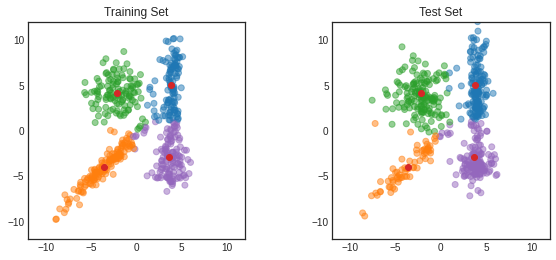



K-Means Objective on Training Set:  6.475559192992271
K-Means Objective on Test Set:  6.226942004780743


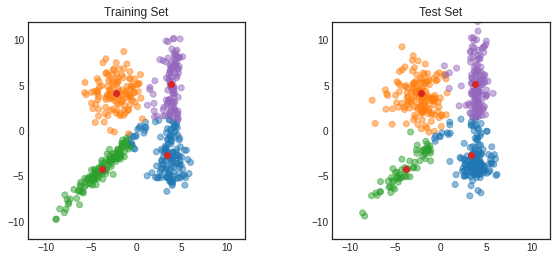



K-Means Objective on Training Set:  6.476276886129608
K-Means Objective on Test Set:  6.205199848006528


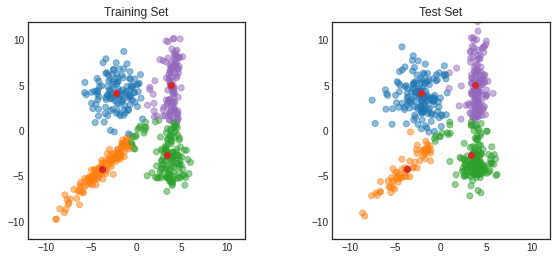

In [ ]:
for run in range(3):
    KM_centroids, KM_predictor = KMeans(X_train, K=4)
    show_kmeans(X_train, X_test, KM_centroids, KM_predictor)

We have trained your implementation of the K-Means algorithm using `X_train` for 3 different initializations. 

**Question:** Briefly compare the results above in terms of the location of the centers and the K-means training objective (at convergence) across runs with different initializations. What conclusions can you draw from this? 

**Answer:** The location of the centroids does not vary by much. We can tell by looking at the training loss and the test loss. 

The convergence on the training set is the same for the accross the different k-means++ initialization, up to a difference of 0.15% on the training loss. 

|Run|Training loss | Test loss|
| -- | -- | -- |
|1 | 6.481  |  6.147 |
| 2 | 6.476 |  6.205 |
| 3 | 6.480 | 6.128 | 

Variance of loss 

|Training loss variance | Test loss variance|
| -- | -- |
| $7 \times 10^{-6}$  |  $2 \times 10^{-3}$ |


This very small difference in the position of the centroids can lead to a difference of up 1% in the test loss for different initialization. 

### EM for Gaussian mixture models 

Scaled identity covariance matrices
MoG Normalized Log-Likelihood Training Set:  -5.6822816574798365
MoG Normalized Log-Likelihood Test Set:  -5.666225313186463


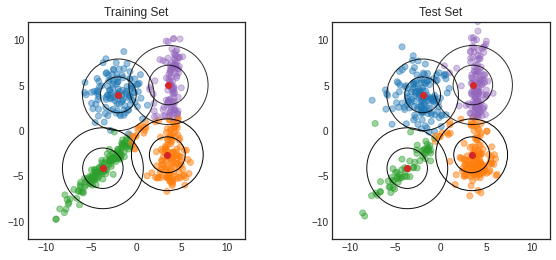




Full covariance matrices
MoG Normalized Log-Likelihood Training Set:  -4.689948700290857
MoG Normalized Log-Likelihood Test Set:  -4.852537198703139


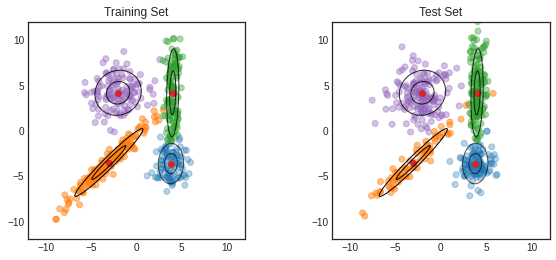

In [ ]:
print('Scaled identity covariance matrices')
MoG1 = GaussianMixture(X_train, K=4, use_full_cov=False)
show_mog(X_train, X_test, MoG1[0], MoG1[1], MoG1[2], MoG1[3])

print('\nFull covariance matrices')
MoG2 = GaussianMixture(X_train, K=4, use_full_cov=True)
show_mog(X_train, X_test, MoG2[0], MoG2[1], MoG2[2], MoG2[3])

We have trained your implementation of the EM algorithm for a Gaussian mixture model using `X_train`. The plots show the behavior on the training and testing (left and right) sets when using scaled diagonal or full covariance matrices (top and bottom), respectively. 

**Question:** Briefly compare the results above in terms of the location of the centers and the normalized log-likelihood between the training and test set. What conclusions can you draw from this? 

**Answer:** The location of the centroids is very similar between the the spherical covariance GMM and the full covariance GMM. 
The log-likelihood is higher for the full covariance, and comparable between the training set and test set (which means the GMM model has captured well the distribution of the training set).

### Bonus
**Question:** From your observations on the K-Means and EM sections, is there any relation one can stablish between these two methods? f so, how do the plots above reflect this?  

**Answer:** 